## Machine Learning HW4

**Name: Varad Paradkar || ID: 801418318**

In [2]:
# Import libraries
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from os.path import join
import struct
from array import array
import random

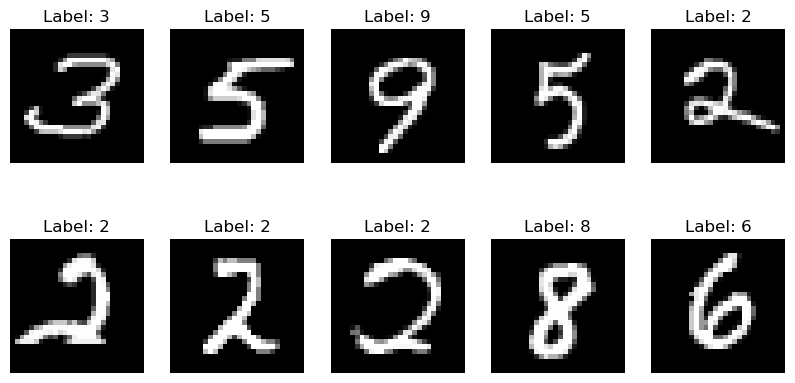

In [3]:
# Define MnistDataloader class to load MNIST data
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            _, size = struct.unpack(">II", file.read(8))
            labels = array("B", file.read())
        
        with open(images_filepath, 'rb') as file:
            _, size, rows, cols = struct.unpack(">IIII", file.read(16))
            image_data = array("B", file.read())
        
        # Reshape image data and return as list of images and labels
        images = [np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(28, 28) for i in range(size)]
        return images, labels
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

# Set dataset file paths
input_path = './dataset/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Initialize dataloader and load data
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Convert data to PyTorch tensors and reshape for CNN input
x_train_tensor = torch.tensor(np.array(x_train), dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
x_test_tensor = torch.tensor(np.array(x_test), dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)

# Create DataLoaders for training and testing
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Display a batch of images
def show_images(images, labels, rows=2, cols=5):
    plt.figure(figsize=(10, 5))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Get and display a sample batch of training images
sample_images, sample_labels = next(iter(train_loader))
show_images(sample_images, sample_labels)

In [4]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1x28x28 -> 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 32x28x28 -> 64x28x28
        
        # Max Pooling and Dropout
        self.pool = nn.MaxPool2d(2, 2)  # Downsamples by 2 -> 64x14x14
        self.dropout = nn.Dropout(0.25)  # Reduces overfitting

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # 64*14*14 -> 128
        self.fc2 = nn.Linear(128, 10)  # 128 -> 10 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 14 * 14)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output logits for each class
        return x

# Initialize model, loss function, and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate 0.001


In [5]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    train_loss = []  
    test_loss = []  

    model.train()  # Set model to training mode
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0  
        running_test_loss = 0.0  

        # Training phase
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)
            
            # Compute loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  # Update weights
            
            running_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        
        # Testing phase
        model.eval()  # Set model to evaluation mode
        
        with torch.no_grad():  # Disable gradient tracking
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        # Average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_loader)
        test_loss.append(epoch_test_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
        
        model.train()  # Back to training mode

    return train_loss, test_loss

# Train the model and track loss
train_loss, test_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5 - Train Loss: 0.2183, Test Loss: 0.0726
Epoch 2/5 - Train Loss: 0.0713, Test Loss: 0.0609
Epoch 3/5 - Train Loss: 0.0526, Test Loss: 0.0570
Epoch 4/5 - Train Loss: 0.0437, Test Loss: 0.0693
Epoch 5/5 - Train Loss: 0.0351, Test Loss: 0.0526


In [6]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()

    correct = 0  # number of correct predictions
    total = 0  # total number of test samples
    
    # Disable gradient tracking 
    with torch.no_grad():
        # Loop through the test dataset 
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update number of test samples
            total += labels.size(0)

            # Update the count of correct predictions
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy as the ratio of correct predictions to total samples
    accuracy = 100 * correct / total

    print(f'Accuracy on test set: {accuracy:.2f}%')
    
    return accuracy

# Evaluate model
test_accuracy = evaluate_model(model, test_loader)


Accuracy on test set: 98.69%


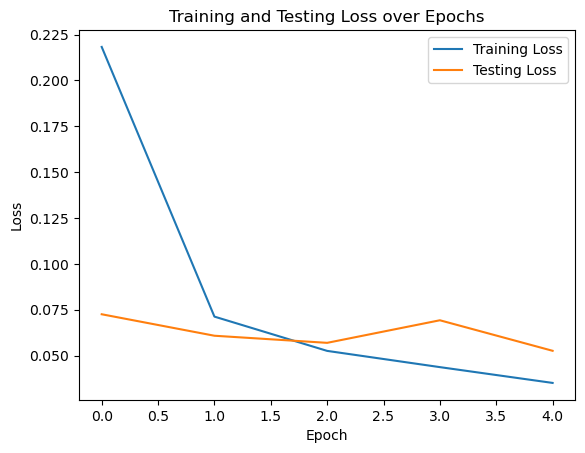

In [7]:
# Plot training and testing loss
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()